In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.tinto import TINTO
from vit_pytorch.vit import ViT
from kan import *


import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch.optim as optim
import torch

In [16]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
folder="data/1000-Cameras-Dataset"
x_col=["Release_date", "Max_resolution", "Low_resolution", "Effective_pixels", "Zoom", "Normal_focus_range", "Macro_focus_range", "Storage_included","Weight","Dimensions"]
target_col=["price"]

In [5]:
def load_and_impute(npy_filename, y_filename, x_col, target_col, folder):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    compute the mean for each numerical column, and replace NaN values
    with the column mean for numerical columns and '_new_' for non-numerical.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"The number of rows in {npy_filename} and {y_filename} do not match.")
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X, columns=x_col)
    df_y = pd.DataFrame(y, columns=target_col)

    # Compute mean values for numerical columns
    numerical_means = df_X.select_dtypes(include=[np.number]).mean()

    # Replace NaNs: numerical with mean, non-numerical with '_new_'
    df_X = df_X.apply(lambda col: col.fillna(numerical_means[col.name]) if col.name in numerical_means else col.fillna('_new_'))

    return df_X, df_y

X_train, y_train = load_and_impute('N_train.npy', 'y_train.npy', x_col, target_col, folder)
X_test, y_test   = load_and_impute('N_test.npy',  'y_test.npy', x_col, target_col, folder)
X_val, y_val     = load_and_impute('N_val.npy',   'y_val.npy', x_col, target_col, folder)

In [6]:
X_train = pd.concat([X_train, y_train], axis=1)
X_test = pd.concat([X_test, y_test], axis=1)
X_val = pd.concat([X_val, y_val], axis=1)

In [7]:
def load_and_preprocess_data(X_train, X_test, X_val, images_folder, image_model, problem_type, batch_size=32, device='cuda'):
    """Loads, processes, and converts a dataset into PyTorch DataLoaders for a ViT + KAN model."""
    
    # Reset indices
    data_splits = {
        "train": X_train.reset_index(drop=True), 
        "val": X_val.reset_index(drop=True), 
        "test": X_test.reset_index(drop=True)
    }
    
    # Process images and numerical features
    num_features, img_paths, targets = {}, {}, {}

    for split, X_split in data_splits.items():
        split_folder = f"{images_folder}/{split}"
        os.makedirs(split_folder, exist_ok=True)

        # Ensure images and CSV files are generated
        image_model.fit_transform(X_split, split_folder) if split == "train" else image_model.transform(X_split, split_folder)

        # Validate CSV file existence
        csv_path = os.path.join(split_folder, f"{problem_type}.csv")
        if not os.path.exists(csv_path):
            print(f"Error: Missing CSV at {csv_path}. Available files: {os.listdir(split_folder)}")
            raise FileNotFoundError(f"Expected file {csv_path} not found. Ensure image_model generates it.")

        print(f"Loading {csv_path}...")
        img_df = pd.read_csv(csv_path)
        img_df["images"] = split_folder + "/" + img_df["images"]

        # Combine numerical data and images
        combined_df = pd.concat([img_df, X_split], axis=1)
        num_features[split] = combined_df.drop(columns=["values", "images", X_train.columns[-1]])
        img_paths[split] = img_df["images"]
        targets[split] = combined_df["values"]

    # Standardize numerical data
    scaler = StandardScaler()
    for split in ["train", "val", "test"]:
        num_features[split] = pd.DataFrame(scaler.fit_transform(num_features[split]) if split == "train" 
                                           else scaler.transform(num_features[split]), 
                                           columns=num_features[split].columns)

    # Convert images to tensors
    img_tensors = {split: torch.tensor(np.array([cv2.imread(img) for img in img_paths[split]]), 
                                       dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
                   for split in ["train", "val", "test"]}
    
    # Get dataset properties
    attributes = num_features["train"].shape[1]
    channels, height, width = img_tensors["train"].shape[1:]
    imgs_shape = (channels, height, width)

    print("Images shape:", imgs_shape)
    print("Attributes:", attributes)

    # Convert numerical data and targets to tensors
    num_tensors = {split: torch.tensor(num_features[split].values, dtype=torch.float32, device=device)
                   for split in ["train", "val", "test"]}
    
    target_tensors = {split: torch.tensor(targets[split].values, dtype=torch.float32, device=device).reshape(-1, 1)
                      for split in ["train", "val", "test"]}

    # Create DataLoaders
    datasets = {split: TensorDataset(num_tensors[split], img_tensors[split], target_tensors[split]) 
                for split in ["train", "val", "test"]}
    
    data_loaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=(split == "train")) 
                    for split in ["train", "val", "test"]}

    return data_loaders["train"], data_loaders["val"], data_loaders["test"], attributes, imgs_shape

In [8]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [9]:
from TINTOlib.igtd import IGTD
dataset_name = '1000cameras'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [10]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, X_test, X_val,
    images_folder=images_folder,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

Loading HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_4x4_fEuclidean_iEuclidean_abs/train\regression.csv...
Loading HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_4x4_fEuclidean_iEuclidean_abs/val\regression.csv...
Loading HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_4x4_fEuclidean_iEuclidean_abs/test\regression.csv...
Images shape: (3, 4, 4)
Attributes: 10


In [11]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model1, self).__init__()
        self.device = device
        # KAN branch
        self.m_kan = KAN(
            width=[attributes, 21],
            grid=5,
            k=3,
            seed=SEED,
            device=device
        )
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        
        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.cnn_output_size + 21, 1],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )


    def forward(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, cnn_output), dim=1)
        return self.final_kan(concat_output)

In [12]:
def try_create_model(model_class, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [17]:
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


In [18]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [17]:
def compile_and_fit_2(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=10, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    pbar = tqdm(range(epochs), desc='description', ncols=100)
    #for epoch in range(epochs):
    for epoch in pbar:
        epoch_start_time = time.time()
        
        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        pbar.set_description("| train_rmse: %.2e | val_rmse: %.2e | " % (train_rmse, val_rmse))
    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics


In [18]:
metrics = compile_and_fit_2(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", device='cuda',
                            batch_size=32, epochs=20, min_lr=1e-4, max_lr=4e-3, weight_decay=1e-2)

| train_rmse: 6.75e+02 | val_rmse: 7.36e+02 | : 100%|███████████████| 20/20 [03:15<00:00,  9.75s/it]



Training completed in 195.07 seconds
Best model found at epoch 20/20
Best Train Loss: 481264.3165, Best Val Loss: 513299.3203
Best Train MSE: 455279.8438, Best Val MSE: 542020.5000
Best Train RMSE: 674.7443, Best Val RMSE: 736.2204
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


In [20]:
metrics = compile_and_fit_2(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", device='cuda',
                            batch_size=32, epochs=10, min_lr=1e-2, max_lr=1, weight_decay=1e-1)

| train_rmse: 6.17e+02 | val_rmse: 6.96e+02 | : 100%|███████████████| 10/10 [01:38<00:00,  9.84s/it]



Training completed in 98.40 seconds
Best model found at epoch 1/10
Best Train Loss: 174634.5623, Best Val Loss: 392041.5284
Best Train MSE: 174648.0156, Best Val MSE: 414289.5000
Best Train RMSE: 417.9091, Best Val RMSE: 643.6533
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


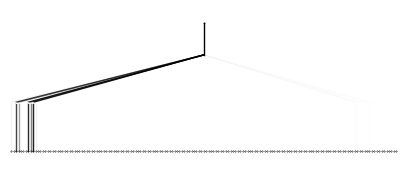

In [53]:
model1.final_kan.plot()

In [56]:
metrics = compile_and_fit_2(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=40, min_lr=1e-4, max_lr=4e-1, device='cuda', weight_decay=1e-2)

| train_rmse: 3.37e+02 | val_rmse: 6.42e+02 | : 100%|███████████████| 40/40 [05:27<00:00,  8.18s/it]



Training completed in 327.12 seconds
Best model found at epoch 1/40
Best Train Loss: 134095.4410, Best Val Loss: 341094.8945
Best Train MSE: 134931.4219, Best Val MSE: 360080.3438
Best Train RMSE: 367.3301, Best Val RMSE: 600.0670
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


In [31]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

def fit_hybrid_dataloaders(model, 
                           train_loader, 
                           val_loader, 
                           test_loader, 
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    device = next(model.parameters()).device

    # Combine dataloaders into tensors.
    train_mlp, train_img, train_target = combine_loader(train_loader)
    val_mlp, val_img, val_target = combine_loader(val_loader)
    test_mlp, test_img, test_target = combine_loader(test_loader)
    
    dataset = {
        "train_mlp": train_mlp.to(device),
        "train_img": train_img.to(device),
        "train_target": train_target.to(device),
        "val_mlp": val_mlp.to(device),
        "val_img": val_img.to(device),
        "val_target": val_target.to(device),
        "test_mlp": test_mlp.to(device),
        "test_img": test_img.to(device),
        "test_target": test_target.to(device),
    }

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_mlp"].shape[0]
    n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            model.m_kan.update_grid(dataset["train_mlp"][train_indices])

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_mlp"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_mlp"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results


In [32]:
metrics = fit_hybrid_dataloaders(model1, train_loader, val_loader, test_loader, steps=10)


Training:   0%|                                                              | 0/10 [00:00<?, ?it/s]
| train_loss: 5.84e+02 | eval_loss: 6.64e+02 | reg: 0.00e+00 |:   0%|        | 0/10 [00:01<?, ?it/s]
| train_loss: 5.84e+02 | eval_loss: 6.64e+02 | reg: 0.00e+00 |:  10%| | 1/10 [00:01<00:09,  1.08s/it
| train_loss: 7.05e+02 | eval_loss: 7.10e+02 | reg: 0.00e+00 |:  10%| | 1/10 [00:02<00:09,  1.08s/it
| train_loss: 7.05e+02 | eval_loss: 7.10e+02 | reg: 0.00e+00 |:  20%|▏| 2/10 [00:02<00:08,  1.05s/it
| train_loss: 6.95e+02 | eval_loss: 6.56e+02 | reg: 0.00e+00 |:  20%|▏| 2/10 [00:03<00:08,  1.05s/it
| train_loss: 6.95e+02 | eval_loss: 6.56e+02 | reg: 0.00e+00 |:  30%|▎| 3/10 [00:03<00:07,  1.08s/it
| train_loss: 6.02e+02 | eval_loss: 6.66e+02 | reg: 0.00e+00 |:  30%|▎| 3/10 [00:04<00:07,  1.08s/it
| train_loss: 6.02e+02 | eval_loss: 6.66e+02 | reg: 0.00e+00 |:  40%|▍| 4/10 [00:04<00:06,  1.09s/it
| train_loss: 6.15e+02 | eval_loss: 5.83e+02 | reg: 0.00e+00 |:  40%|▍| 4/10 [00:05<00:06,

saving model version 0.1


Training:   0%|                                                              | 0/10 [07:04<?, ?it/s]


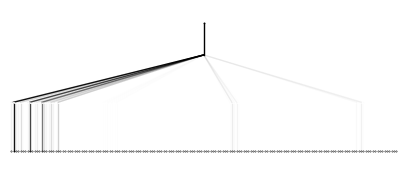

In [33]:
model1.final_kan.plot()

In [31]:
metrics = compile_and_fit_2(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=40, min_lr=1e-4, max_lr=4e-1, device='cuda', weight_decay=1e-3)

| train_rmse: 2.99e+02 | val_rmse: 6.32e+02 | : 100%|███████████████| 40/40 [04:32<00:00,  6.81s/it]



Training completed in 272.57 seconds
Best model found at epoch 28/40
Best Train Loss: 105591.4686, Best Val Loss: 364157.9268
Best Train MSE: 106593.3984, Best Val MSE: 384182.4062
Best Train RMSE: 326.4865, Best Val RMSE: 619.8245
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


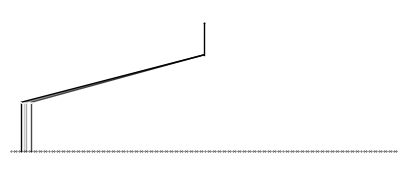

In [32]:
model1.final_kan.plot()

In [23]:
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model2, self).__init__()
        self.device = device
        # KAN branch
        self.m_kan = KAN(
            width=[attributes, 8],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + 8, 1],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_cnn_input = torch.zeros(1, *imgs_shape, device=device)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        
        return cnn_output.size(1)


    def forward(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, cnn_output), dim=1)
        return self.final_kan(concat_output)

In [27]:
model2 = try_create_model(Model2, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model2


In [27]:
metrics = compile_and_fit_2(model2, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model2", device='cuda',
                            batch_size=32, epochs=20, min_lr=1e-4, max_lr=4e-1, weight_decay=1e-2)

| train_rmse: 3.61e+02 | val_rmse: 6.39e+02 | : 100%|███████████████| 20/20 [02:42<00:00,  8.11s/it]



Training completed in 162.18 seconds
Best model found at epoch 10/20
Best Train Loss: 201451.6917, Best Val Loss: 362719.1428
Best Train MSE: 202708.5625, Best Val MSE: 379645.7500
Best Train RMSE: 450.2317, Best Val RMSE: 616.1540
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model2/best_model.pth


In [23]:
metrics = compile_and_fit_2(model2, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model2", device='cuda',
                            batch_size=32, epochs=20, min_lr=1e-4, max_lr=4e-1, weight_decay=1e-2)

| train_rmse: 3.53e+02 | val_rmse: 6.43e+02 | : 100%|███████████████| 20/20 [02:27<00:00,  7.35s/it]



Training completed in 147.09 seconds
Best model found at epoch 5/20
Best Train Loss: 274424.1719, Best Val Loss: 388146.9885
Best Train MSE: 277298.8438, Best Val MSE: 409868.3438
Best Train RMSE: 526.5917, Best Val RMSE: 640.2096
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model2/best_model.pth


In [21]:
def compile_and_fit_hybrid(model, train_loader, val_loader, test_loader,
                           dataset_name, model_name,
                           batch_size=32, epochs=10,
                           min_lr=1e-4, max_lr=4e-3,
                           device='cuda', weight_decay=1e-2,
                           update_grid=True, grid_update_num=10,
                           start_grid_update_step=0, stop_grid_update_step=50,
                           lamb=0.0, lamb_l1=1.0, lamb_entropy=2.0, 
                           lamb_coef=0.0, lamb_coefdiff=0.0,
                           singularity_avoiding=False, y_th=1000.,
                           save_fig=False, save_fig_freq=1, img_folder='./video'):
    """
    Trains a hybrid model (KAN branch + CNN branch) with features inspired by KAN.fit.
    
    Besides the usual MSE loss, this routine can update each KAN branch’s grid periodically and 
    add regularization penalties if enabled. It uses OneCycleLR for learning rate scheduling and saves 
    the best model (by validation loss).
    
    Returns:
        metrics: dictionary containing losses, MSE, RMSE, R2 and timing information.
    """
    import copy, os, time, gc
    from tqdm import tqdm
    import torch.nn as nn
    import torch.optim as optim
    from torch.optim.lr_scheduler import OneCycleLR
    # Ensure loss_fn is MSE
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=(max_lr/min_lr),
                            total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': [], 'learning_rate': [], 'epoch_time': []}
    
    # Determine grid update frequency (in steps)
    grid_update_freq = total_steps // grid_update_num if update_grid else None
    global_step = 0
    overall_start_time = time.time()
    
    pbar = tqdm(range(epochs), desc='Epoch', ncols=100)
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss_epoch = 0.0
        
        for batch_idx, (num_data, img_data, targets) in enumerate(train_loader):
            num_data = num_data.to(device, non_blocking=True)
            img_data = img_data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Perform grid update if enabled and if within the scheduled steps
            if update_grid and grid_update_freq is not None:
                if (global_step % grid_update_freq == 0 and 
                    global_step >= start_grid_update_step and 
                    global_step < stop_grid_update_step):
                    # Update the grid for the KAN branch that processes numerical features
                    if hasattr(model.m_kan, 'update_grid'):
                        model.m_kan.update_grid(num_data)
                    # For the final KAN branch, update using the concatenated input.
                    if hasattr(model.final_kan, 'update_grid'):
                        # Do a forward pass through the first branches only (without final_kan)
                        with torch.no_grad():
                            kan_out = model.m_kan(num_data)
                            cnn_out = model.cnn_branch(img_data)
                            concat_in = torch.cat((kan_out, cnn_out), dim=1)
                        model.final_kan.update_grid(concat_in)
            
            # Forward pass through the hybrid model
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            
            # Optionally add regularization from the KAN branches (if enabled)
            reg_loss = 0.0
            if hasattr(model.m_kan, 'save_act') and model.m_kan.save_act:
                reg_loss += model.m_kan.get_reg('edge_forward_spline_n', lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            if hasattr(model.final_kan, 'save_act') and model.final_kan.save_act:
                reg_loss += model.final_kan.get_reg('edge_forward_spline_n', lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            
            total_loss = loss + lamb * reg_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss_epoch += total_loss.item()
            global_step += 1
        
        train_loss_epoch /= len(train_loader)
        
        # Validation loop
        model.eval()
        val_loss_epoch = 0.0
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data = num_data.to(device, non_blocking=True)
                img_data = img_data.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                val_loss_epoch += loss.item()
        val_loss_epoch /= len(val_loader)
        
        epoch_time = time.time() - epoch_start_time
        current_lr = scheduler.get_last_lr()[0]
        
        history['train_loss'].append(train_loss_epoch)
        history['val_loss'].append(val_loss_epoch)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        
        pbar.set_description(f"Epoch {epoch+1}/{epochs} | train_loss: {train_loss_epoch:.2e} | val_loss: {val_loss_epoch:.2e}")
        
        # Save best model based on validation loss
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
        
        # Optionally, save model plots if your model supports it
        if save_fig and (epoch + 1) % save_fig_freq == 0:
            if hasattr(model, 'plot'):
                model.plot(folder=img_folder, title=f"Epoch {epoch+1}")
        
    total_time = time.time() - overall_start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch} with validation loss {best_val_loss:.4f}")
    
    # Calculate metrics on train, validation, and test sets
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)
    
    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    # Save best model state
    model_save_path = f"models/Regression/{dataset_name}/Hybrid/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model_state, model_save_path)
    print(f"Best model saved to {model_save_path}")
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return metrics


In [17]:
metrics = compile_and_fit_2(model2, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model2", device='cuda',
                            batch_size=32, epochs=20, min_lr=1e-4, max_lr=4e-3, weight_decay=1e-2)

| train_rmse: 6.14e+02 | val_rmse: 7.21e+02 | : 100%|███████████████| 20/20 [02:13<00:00,  6.70s/it]



Training completed in 134.00 seconds
Best model found at epoch 13/20
Best Train Loss: 407559.8262, Best Val Loss: 475892.2276
Best Train MSE: 402848.2812, Best Val MSE: 502718.6562
Best Train RMSE: 634.7033, Best Val RMSE: 709.0266
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model2/best_model.pth


In [16]:
metrics = compile_and_fit_2(model2, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model2", device='cuda',
                            batch_size=32, epochs=40, min_lr=1e-4, max_lr=4e-1, weight_decay=1e-2)

| train_rmse: 3.38e+02 | val_rmse: 6.71e+02 | : 100%|███████████████| 40/40 [04:29<00:00,  6.75s/it]



Training completed in 269.98 seconds
Best model found at epoch 27/40
Best Train Loss: 144957.2822, Best Val Loss: 382101.1964
Best Train MSE: 137852.3281, Best Val MSE: 404419.0938
Best Train RMSE: 371.2847, Best Val RMSE: 635.9395
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model2/best_model.pth


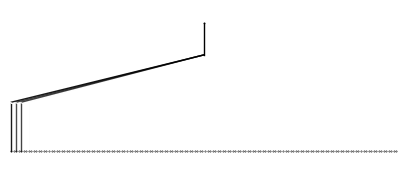

In [24]:
model2.final_kan.plot()

In [26]:
def compile_and_fit_hybrid(model, train_loader, val_loader, test_loader,
                           dataset_name, model_name,
                           batch_size=32, epochs=10,
                           min_lr=1e-4, max_lr=4e-3,
                           device='cuda', weight_decay=1e-2,
                           update_grid=True, grid_update_num=10,
                           start_grid_update_step=0, stop_grid_update_step=50,
                           lamb=0.0, lamb_l1=1.0, lamb_entropy=2.0, 
                           lamb_coef=0.0, lamb_coefdiff=0.0,
                           singularity_avoiding=False, y_th=1000.,
                           save_fig=False, save_fig_freq=1, img_folder='./video'):
    """
    Trains a hybrid model (KAN branch + CNN branch) with features inspired by KAN.fit.
    
    This routine updates the grid for the m_kan branch periodically and adds regularization
    penalties if enabled. It uses OneCycleLR for learning rate scheduling and saves the best model.
    
    Note: The grid update for the final KAN branch is disabled by default to avoid issues in curve2coef.
    
    Returns:
        metrics: dictionary containing losses, MSE, RMSE, R2 and timing information.
    """
    import copy, os, time, gc
    from tqdm import tqdm
    import torch.nn as nn
    import torch.optim as optim
    from torch.optim.lr_scheduler import OneCycleLR

    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=(max_lr/min_lr),
                            total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': [], 'learning_rate': [], 'epoch_time': []}
    
    # Determine grid update frequency (in steps)
    grid_update_freq = total_steps // grid_update_num if update_grid else None
    global_step = 0
    overall_start_time = time.time()
    
    pbar = tqdm(range(epochs), desc='Epoch', ncols=100)
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss_epoch = 0.0
        
        for batch_idx, (num_data, img_data, targets) in enumerate(train_loader):
            num_data = num_data.to(device, non_blocking=True)
            img_data = img_data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Perform grid update if enabled and within scheduled steps
            if update_grid and grid_update_freq is not None:
                if (global_step % grid_update_freq == 0 and 
                    global_step >= start_grid_update_step and 
                    global_step < stop_grid_update_step):
                    # Update grid for the m_kan branch only
                    if hasattr(model.m_kan, 'update_grid'):
                        model.m_kan.update_grid(num_data)
                    
                    # Optionally, you could update final_kan's grid.
                    # This is commented out because it may trigger the curve2coef error.
                    try:
                        with torch.no_grad():
                            kan_out = model.m_kan(num_data)
                            cnn_out = model.cnn_branch(img_data)
                            concat_in = torch.cat((kan_out, cnn_out), dim=1)
                        if hasattr(model.final_kan, 'update_grid'):
                            model.final_kan.update_grid(concat_in)
                    except Exception as e:
                        print("Warning: final_kan grid update failed:", e)
            
            # Forward pass through the hybrid model
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            
            # Optionally add regularization from the KAN branches (if enabled)
            reg_loss = 0.0
            if hasattr(model.m_kan, 'save_act') and model.m_kan.save_act:
                reg_loss += model.m_kan.get_reg('edge_forward_spline_n', lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            if hasattr(model.final_kan, 'save_act') and model.final_kan.save_act:
                reg_loss += model.final_kan.get_reg('edge_forward_spline_n', lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            
            total_loss = loss + lamb * reg_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss_epoch += total_loss.item()
            global_step += 1
        
        train_loss_epoch /= len(train_loader)
        
        # Validation loop
        model.eval()
        val_loss_epoch = 0.0
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data = num_data.to(device, non_blocking=True)
                img_data = img_data.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                val_loss_epoch += loss.item()
        val_loss_epoch /= len(val_loader)
        
        epoch_time = time.time() - epoch_start_time
        current_lr = scheduler.get_last_lr()[0]
        
        history['train_loss'].append(train_loss_epoch)
        history['val_loss'].append(val_loss_epoch)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        
        pbar.set_description(f"Epoch {epoch+1}/{epochs} | train_loss: {train_loss_epoch:.2e} | val_loss: {val_loss_epoch:.2e}")
        
        # Save best model based on validation loss
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
        
        # Optionally, save model plots if available
        if save_fig and (epoch + 1) % save_fig_freq == 0:
            if hasattr(model, 'plot'):
                model.plot(folder=img_folder, title=f"Epoch {epoch+1}")
        
    total_time = time.time() - overall_start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch} with validation loss {best_val_loss:.4f}")
    
    # Calculate metrics on train, validation, and test sets
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)
    
    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    # Save best model state
    model_save_path = f"models/Regression/{dataset_name}/Hybrid/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model_state, model_save_path)
    print(f"Best model saved to {model_save_path}")
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return metrics


In [20]:
metrics = compile_and_fit_hybrid(
    model1, train_loader, val_loader, test_loader,
    dataset_name, f"{dataset_name}_Model1",
    batch_size=32, epochs=20,
    min_lr=1e-4, max_lr=4e-1,
    device='cuda', weight_decay=1e-1)


Epoch:   0%|                                                                 | 0/20 [00:00<?, ?it/s]
Epoch 1/20 | train_loss: 4.85e+05 | val_loss: 5.41e+05:   0%|                | 0/20 [00:08<?, ?it/s]
Epoch 2/20 | train_loss: 4.73e+05 | val_loss: 5.10e+05:   0%|                | 0/20 [00:15<?, ?it/s]
Epoch 3/20 | train_loss: 4.48e+05 | val_loss: 4.77e+05:   0%|                | 0/20 [00:22<?, ?it/s]
Epoch 4/20 | train_loss: 4.28e+05 | val_loss: 4.84e+05:   0%|                | 0/20 [00:29<?, ?it/s]
Epoch 5/20 | train_loss: 4.44e+05 | val_loss: 5.84e+05:   0%|                | 0/20 [00:36<?, ?it/s]
Epoch 6/20 | train_loss: 4.03e+05 | val_loss: 5.42e+05:   0%|                | 0/20 [00:43<?, ?it/s]
Epoch 7/20 | train_loss: 4.57e+05 | val_loss: 5.02e+05:   0%|                | 0/20 [00:50<?, ?it/s]
Epoch 8/20 | train_loss: 4.45e+05 | val_loss: 5.35e+05:   0%|                | 0/20 [00:57<?, ?it/s]
Epoch 9/20 | train_loss: 4.47e+05 | val_loss: 5.06e+05:   0%|                | 0/20 [01:03


Training completed in 142.04 seconds
Best model found at epoch 13 with validation loss 419148.0476


Epoch 20/20 | train_loss: 3.65e+05 | val_loss: 4.32e+05:   0%|               | 0/20 [02:24<?, ?it/s]

Best model saved to models/Regression/1000cameras/Hybrid/1000cameras_Model1/best_model.pth


In [ ]:
metrics = compile_and_fit_hybrid(
    model2, train_loader, val_loader, test_loader,
    dataset_name, f"{dataset_name}_Model1",
    batch_size=32, epochs=10,
    min_lr=1e-4, max_lr=4e-1,
    device='cuda', weight_decay=1e-1)


Epoch:   0%|                                                                 | 0/10 [00:00<?, ?it/s]

lstsq failed
